# <center>Stock Price Analysis (AAPL - Apple Inc.) </center> 
#  <center> Time Series Forecasting with SARIMA and Prophet</center> 
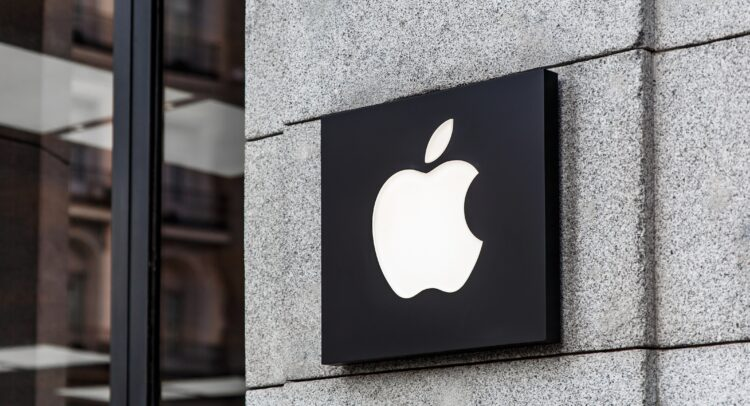

#### Context
In this project, we will study the stock AAPL (the ticker symbol for Apple Inc.). We will use the yfinance API to fetch a dataset of AAPL's historical stock prices over a period of time. This data is typically used for financial analysis, including studying trends in the stock price, predicting future prices, or analyzing the volatility of the stock.
</br></br>

#### Content
- Date: The specific date of the stock prices listed.
- Open: The price at which Apple's stock opened on that particular day.
- High: The highest price Apple’s stock reached during that day.
-Low: The lowest price Apple’s stock reached during that day.
- Close: The price at which Apple's stock closed on that day.
- Adj Close: The adjusted closing price, which reflects the stock's closing price after adjustments for any actions such as dividends or stock splits.
- Volume: The number of shares traded on that particular day.
</br></br>

We will use this dataset to perform analyses with Prophet and ARIMA/SARIMA models to predict future close prices.

In [1]:
# !pip install prophet
# !pip install yfinance
# !pip install pmdarima
# !pip install tabulate
# !pip install plotly

In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from tabulate import tabulate
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from sklearn.model_selection import TimeSeriesSplit
from prophet import Prophet
from prophet.diagnostics import cross_validation
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

## Import and read time series data

In [3]:
# Downloading stock data for AAPL (Apple Inc.) over the past 5 years with a daily interval
# You can replace the ticker "AAPL" with another ticker symbol (e.g., "GOOGL" for Alphabet) 
# Find the list of assets here: https://finance.yahoo.com/markets/stocks/trending/
# You can modify the 'period' parameter (e.g., "1y" for 1 year or "10y" for 10 years)
df = yf.download("AAPL", period="5y", interval="1d")
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-09-18,55.264999,55.712502,54.860001,55.692501,53.890518,101360000
2019-09-19,55.502499,55.939999,55.092499,55.240002,53.452652,88242400
2019-09-20,55.345001,55.639999,54.367500,54.432499,52.671284,221652400
2019-09-23,54.737499,54.959999,54.412498,54.680000,52.910774,76662000
2019-09-24,55.257500,55.622501,54.297501,54.419998,52.659187,124763200


In [4]:
df.shape

(1258, 6)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2019-09-18 to 2024-09-17
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1258 non-null   float64
 1   High       1258 non-null   float64
 2   Low        1258 non-null   float64
 3   Close      1258 non-null   float64
 4   Adj Close  1258 non-null   float64
 5   Volume     1258 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 68.8 KB


## Data visualization

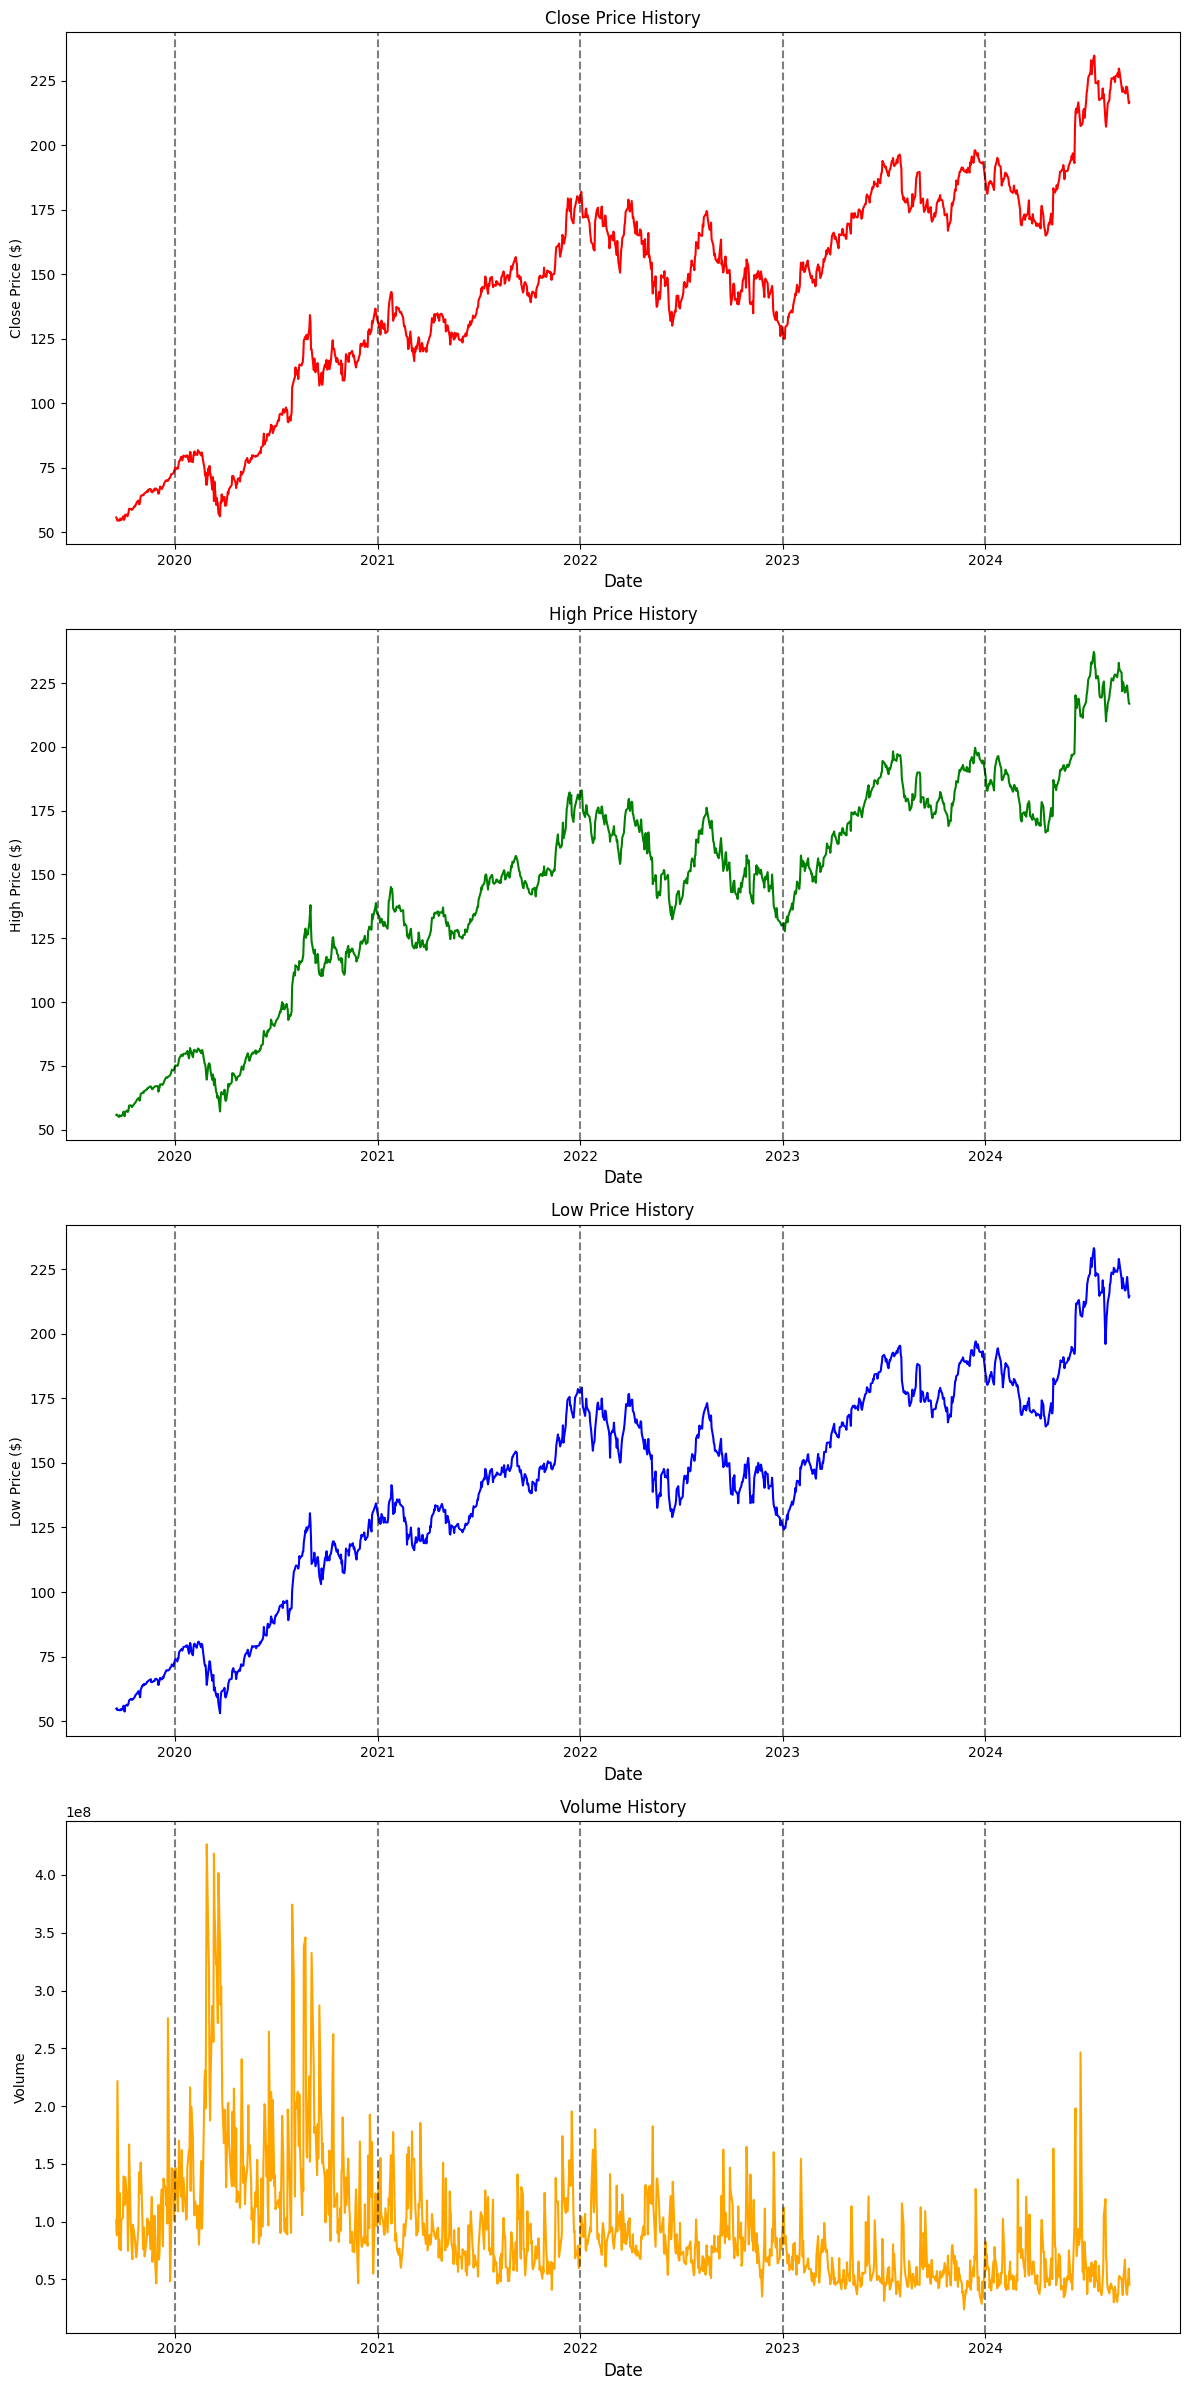

In [6]:
# Create the figure and axes
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 24))

# Close Price Plot
ax1.plot(df.index, df["Close"], color="red")
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Close Price ($)")
ax1.set_title("Close Price History")

# High Price Plot
ax2.plot(df.index, df["High"], color="green")
ax2.set_xlabel("Date", fontsize=12)
ax2.set_ylabel("High Price ($)")
ax2.set_title("High Price History")

# Low Price Plot
ax3.plot(df.index, df["Low"], color="blue")
ax3.set_xlabel("Date", fontsize=12)
ax3.set_ylabel("Low Price ($)")
ax3.set_title("Low Price History")

# Volume Plot
ax4.plot(df.index, df["Volume"], color="orange")
ax4.set_xlabel("Date", fontsize=12)
ax4.set_ylabel("Volume")
ax4.set_title("Volume History")

# Add vertical lines for each year in all plots
xcoords = pd.date_range(start=df.index.min(), end=df.index.max(), freq='YS')
for xc in xcoords:
    ax1.axvline(x=xc, color='black', linestyle='--', alpha=0.5)
    ax2.axvline(x=xc, color='black', linestyle='--', alpha=0.5)
    ax3.axvline(x=xc, color='black', linestyle='--', alpha=0.5)
    ax4.axvline(x=xc, color='black', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

## Long-term Trends

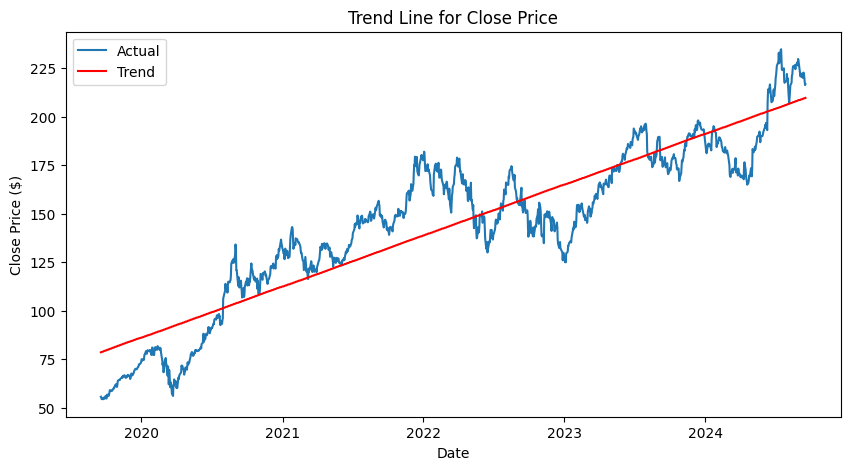

In [7]:
# Linear Regression for Trend Analysis
X = np.arange(len(df)).reshape(-1, 1)  # Time as an independent variable
y = df['Close'].values  # Close price as the dependent variable

# Create and fit the model
model = LinearRegression()
model.fit(X, y)

# Predict the trend
trend = model.predict(X)

# Plot the actual data and the trend line together
plt.figure(figsize=(10, 5))
plt.plot(df.index, y, label='Actual')
plt.plot(df.index, trend, label='Trend', color='red')
plt.title('Trend Line for Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price ($)')
plt.legend()
plt.show()

## Data Preprocessing
We're likely focusing on analyzing and predicting the "Close" price of the AAPL stock, which represents the final price at which the stock was traded during a particular day. Hence, the other columns—Open, High, Low, Volume, and Adj Close—will be dropped because they are not directly relevant to this specific analysis.

In [8]:
df2 = df[['Close']]
df2.head()

,Close
Date,
2019-09-18,55.692501
2019-09-19,55.240002
2019-09-20,54.432499
2019-09-23,54.680000
2019-09-24,54.419998


## Time decomposition

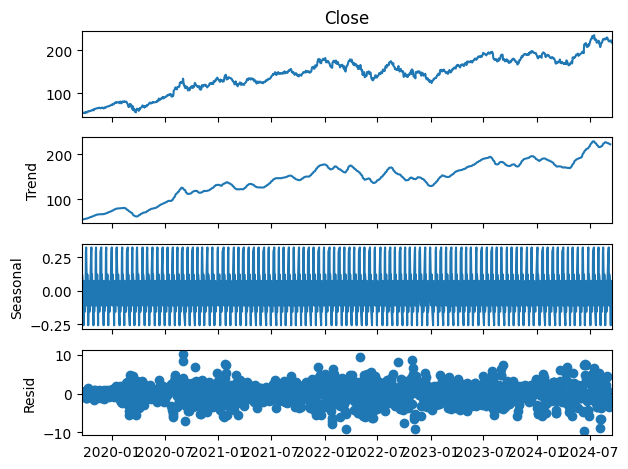

In [9]:
results = seasonal_decompose(df2['Close'], model='additive', period=12)
results.plot()
plt.show()

## Check stationarity

In [10]:
df_diff = df2.dropna()
result = adfuller(df_diff)
table = [
    ['ADF Statistic', result[0]],
    ['P-value', result[1]],
    ['Conclusion', 'The time series is stationary' if result[1] < 0.05 else 'The time series is not stationary']
]
print(tabulate(table, headers=['Metrics', 'Value'], tablefmt='github'))

| Metrics       | Value                             |
|---------------|-----------------------------------|
| ADF Statistic | -1.4523907462915084               |
| P-value       | 0.5569179080741402                |
| Conclusion    | The time series is not stationary |


In [11]:
from pmdarima.arima.utils import ndiffs
d_value = ndiffs(df2,test = "adf")
print("d value:", d_value)

d value: 1


In [12]:
df_diff = df2.diff().dropna()
result = adfuller(df_diff)
table = [
    ['ADF Statistic', result[0]],
    ['P-value', result[1]],
    ['Conclusion', 'The time series is stationary' if result[1] < 0.05 else 'The time series is not stationary']
]
print(tabulate(table, headers=['Metrics', 'Value'], tablefmt='github'))

| Metrics       | Value                         |
|---------------|-------------------------------|
| ADF Statistic | -36.10094994035268            |
| P-value       | 0.0                           |
| Conclusion    | The time series is stationary |


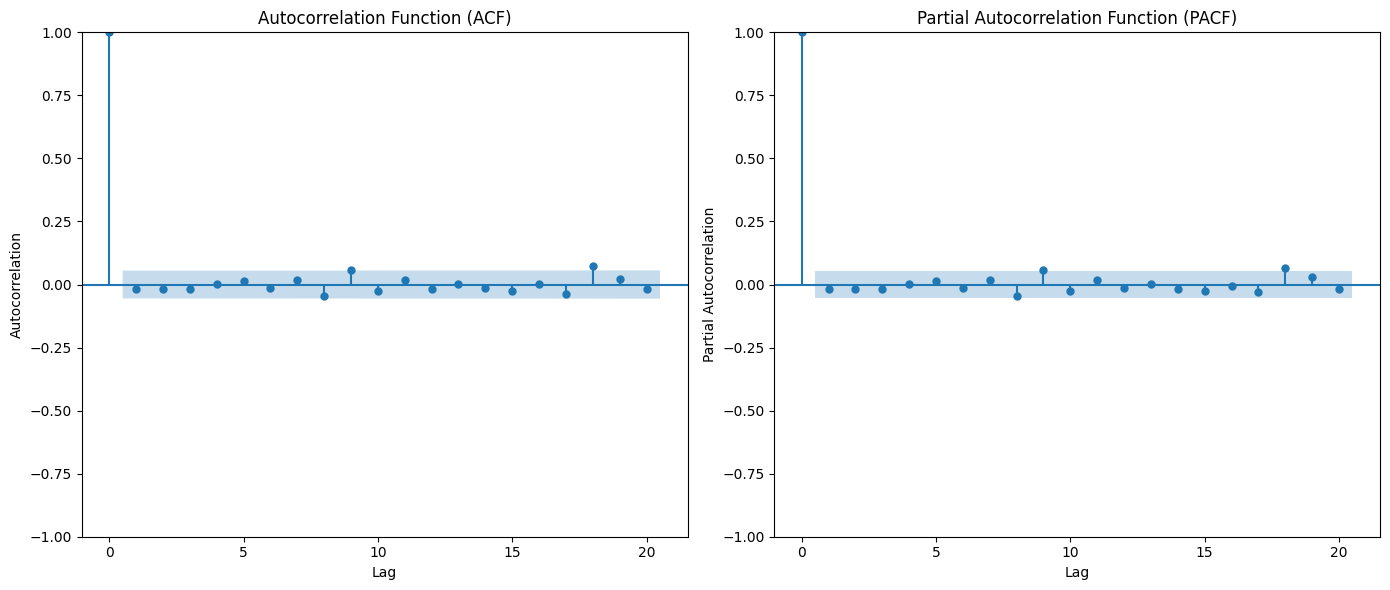

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))  # Create 1 row, 2 columns

# Plot ACF
plot_acf(df2.Close.diff().dropna(), lags=20, ax=ax[0])  # ACF on the left
ax[0].set_xlabel('Lag')
ax[0].set_ylabel('Autocorrelation')
ax[0].set_title('Autocorrelation Function (ACF)')

# Plot PACF
plot_pacf(df2.Close.diff().dropna(), lags=20, ax=ax[1])  # PACF on the right
ax[1].set_xlabel('Lag')
ax[1].set_ylabel('Partial Autocorrelation')
ax[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

## Train / Test Split

In [14]:
split_index = int(len(df2) * 0.8)
df_train = df2.iloc[:split_index]
df_test = df2.iloc[split_index:]
print(len(df_train),len(df_test))

1006 252


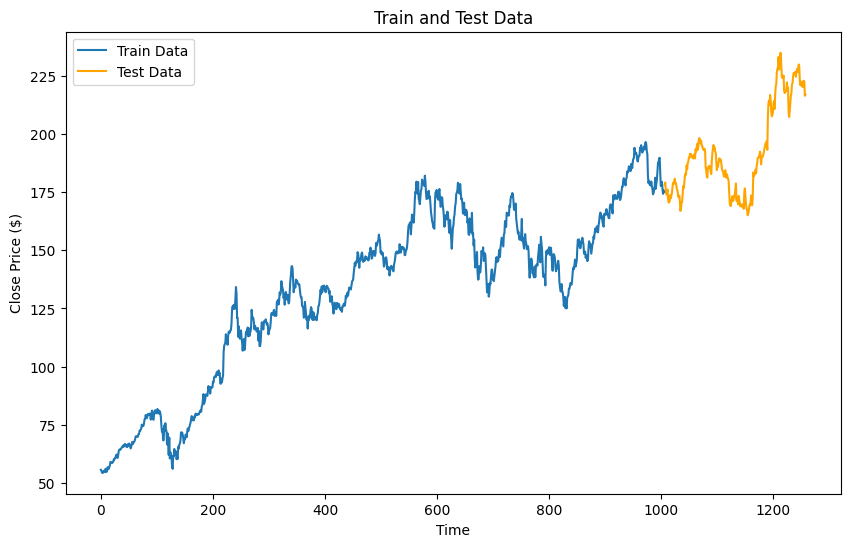

In [15]:
plt.figure(figsize=(10, 6))

# Plot x_train
plt.plot(range(len(df_train)), df_train, label='Train Data')

# Plot x_test
plt.plot(range(len(df_train), len(df_train) + len(df_test)), df_test, label='Test Data', color='orange')

plt.xlabel('Time')
plt.ylabel('Close Price ($)')
plt.title('Train and Test Data')
plt.legend()

plt.show()

## ARIMA

#### Define orders automatically

In [16]:
stepwise_fit = auto_arima(df2,trace=True,suppress_warnings=True)
print(stepwise_fit.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5995.511, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5997.045, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5997.026, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5996.508, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5998.438, Time=1.20 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 4.027 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1258
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2995.755
Date:                Wed, 18 Sep 2024   AIC                           5995.511
Time:                        14:23:39   BIC                           6005.784
Sample:                             0   HQIC                          5999.371
               

#### Fit

In [17]:
m_arima = sm.tsa.arima.ARIMA(df_train, order=stepwise_fit.order).fit()

#### Plot residuals

(array([0.00930794, 0.12220429, 0.01876602, 0.00060051, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00015013]),
 array([-10.51999664,  -3.89874687,   2.7225029 ,   9.34375267,
         15.96500244,  22.58625221,  29.20750198,  35.82875175,
         42.45000153,  49.0712513 ,  55.69250107]),
 <BarContainer object of 10 artists>)

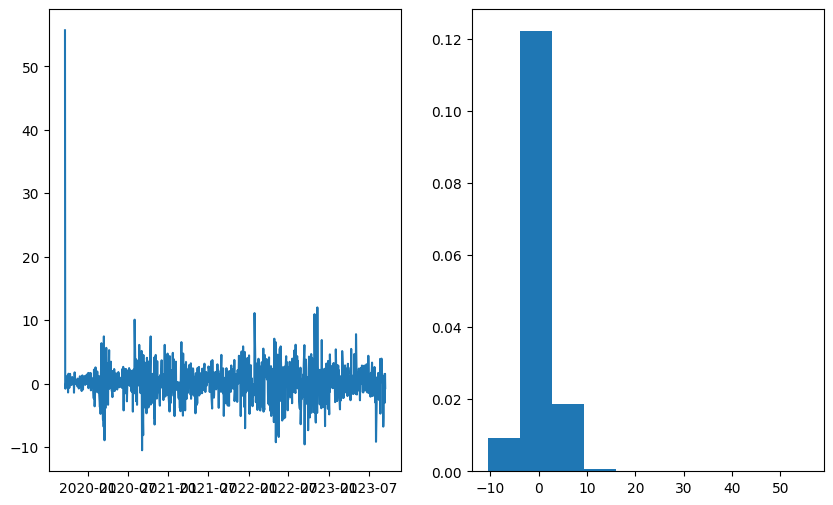

In [18]:
# Get the residuals from the fitted model
residuals = pd.DataFrame(m_arima.resid)

# Create a subplot with 2 plots :  residuals over time and histogral of residuals
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

# Plot residuals over time to check for any patterns or trends
ax1.plot(residuals)
ax2.hist(residuals, density=True)

#### Make prediction

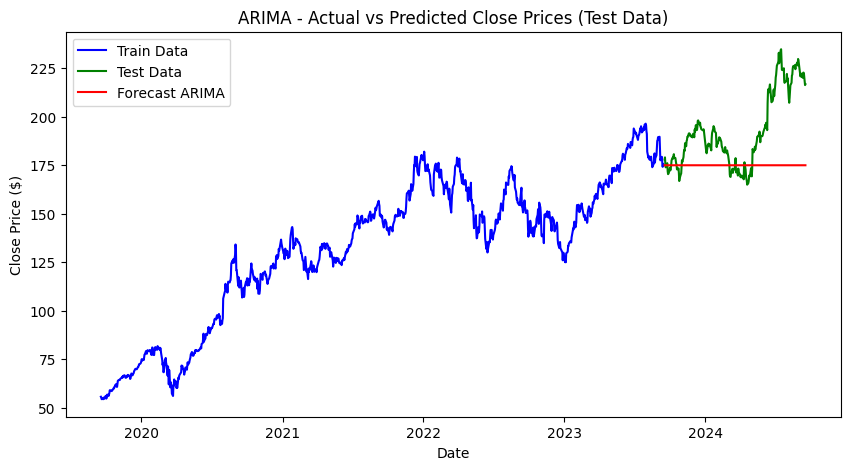

In [19]:
# Predict values for the test dataset
start = len(df_train)
end = len(df_train) + len(df_test) - 1
pred_arima = m_arima.predict(start=start, end=end, typ='levels', dynamic=True)

df_fct = df2.copy()
df_fct['fct_arima'] = None # Initialize the column with None values
df_fct.loc[df_test.index, 'fct_arima'] = pred_arima.values

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(df_train.index, df_train, label='Train Data', color='blue')
plt.plot(df_test.index, df_test, label='Test Data', color='green')
plt.plot(df_fct.index, df_fct['fct_arima'], label='Forecast ARIMA', color='red')

plt.title('ARIMA - Actual vs Predicted Close Prices (Test Data)')
plt.ylabel('Close Price ($)')
plt.xlabel('Date')
plt.legend()
plt.show()

We have seen that simple ARIMA Model is not suitable for this data (There is seasonality in our data)

## SARIMA

#### Define orders automatically

In [20]:
from pmdarima import auto_arima
smodel = auto_arima(
                    df2,
                    seasonal=True, 
                    m=7,
                    max_p=7, 
                    max_d=1, 
                    max_q=3, 
                    max_P=3, 
                    max_D=1, 
                    max_Q=2,
                    trace=True,
                    error_action='ignore',    # To print the progress of the fitting
                    suppress_warnings=True,   # Ignore potential errors
                    sn_jobs=-1)               # Use all available CPU cores
smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=6005.827, Time=4.85 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=5995.511, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=5998.674, Time=0.29 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=5998.646, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=5996.508, Time=0.03 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=5997.090, Time=0.24 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=5997.079, Time=0.26 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=5998.964, Time=0.57 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=5997.045, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=5997.026, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=5998.438, Time=0.68 sec

Best model:  ARIMA(0,1,0)(0,0,0)[7] intercept
Total fit time: 7.597 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1258
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2995.755
Date:                Wed, 18 Sep 2024   AIC                           5995.511
Time:                        14:23:48   BIC                           6005.784
Sample:                             0   HQIC                          5999.371
                               - 1258                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1282      0.074      1.732      0.083      -0.017       0.273
sigma2         6.8801      0.185     37.117      0.000       6.517       7.243
===================================================================================
Ljung-Box (L1) (Q):                   0.47   Jarque-Bera (JB):               297.68
Prob(Q):                              0.49   Prob(JB):                         0.00
Heteroskedasticity (H):               1.16   Skew:                            -0.00
Prob(H) (two-sided):                  0.14   Kurtosis:                         5.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Plot residuals

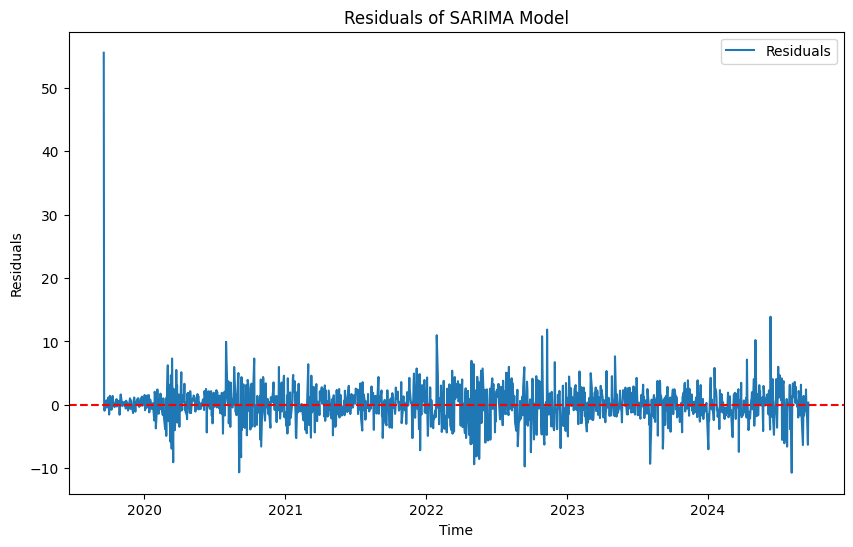

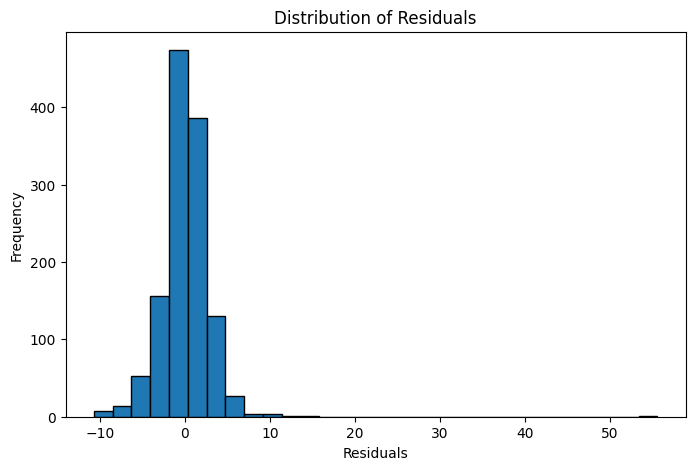

In [21]:
# Get the residuals from the fitted SARIMA model
residuals = smodel.resid()

# Plot the residuals
plt.figure(figsize=(10, 6))
plt.plot(residuals, label='Residuals')
plt.axhline(0, linestyle='--', color='r')
plt.title('Residuals of SARIMA Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()

# Optional: Plot the histogram of residuals
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=30, edgecolor='black')
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()


#### Make predictions

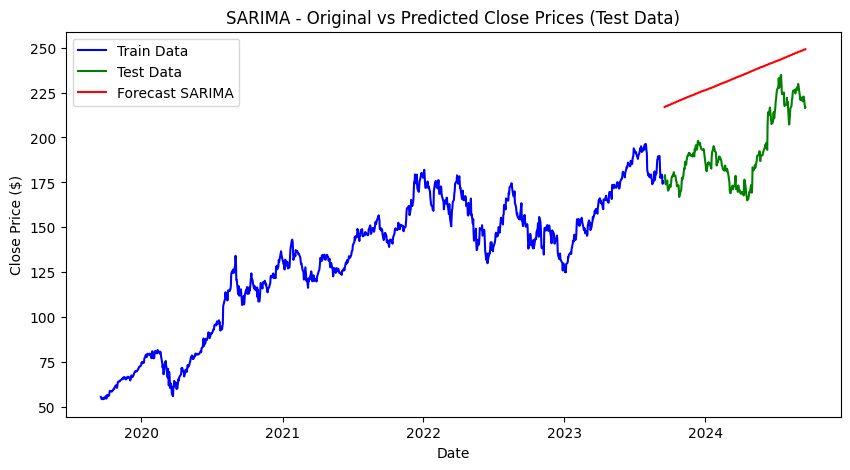

In [22]:
# Make predictions for the test dataset
predictions_sarima = smodel.predict(n_periods=len(df_test))

df_fct['fct_sarima'] = None # Initialize the column with None values
df_fct.loc[df_test.index, 'fct_sarima'] = predictions_sarima.values

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(df_train.index, df_train, label='Train Data', color='blue')
plt.plot(df_test.index, df_test, label='Test Data', color='green')
plt.plot(df_fct.index, df_fct['fct_sarima'], label='Forecast SARIMA', color='red')

plt.title('SARIMA - Original vs Predicted Close Prices (Test Data)')
plt.ylabel('Close Price ($)')
plt.xlabel('Date')
plt.legend()
plt.show()

#### Evaluate the SARIMA Model (rolling cross validation)

In [23]:
# TimeSeriesSplit for rolling cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Initialize lists to store metrics for each fold
mae_sarima_list = []
mape_sarima_list = []
rmse_sarima_list = []

# Rolling cross-validation
for train_index, test_index in tscv.split(df2):
    # Split the data into rolling train and test sets
    train, test = df2.iloc[train_index], df2.iloc[test_index]
    
    # Make predictions on the test set
    predictions = smodel.predict(n_periods=len(test))
    
    # Calculate performance metrics
    mae_sarima = mean_absolute_error(test, predictions)
    mape_sarima = mean_absolute_percentage_error(test, predictions) * 100  # In percentage
    rmse_sarima = np.sqrt(mean_squared_error(test, predictions))
    
    # Append metrics to the respective lists
    mae_sarima_list.append(mae_sarima)
    mape_sarima_list.append(mape_sarima)
    rmse_sarima_list.append(rmse_sarima)

# Calculate average performance metrics across all folds
avg_mae_sarima = np.mean(mae_sarima_list)
avg_mape_sarima = np.mean(mape_sarima_list)
avg_rmse_sarima = np.mean(rmse_sarima_list)

# Print the average metrics
performance = pd.DataFrame({
    'Metrics': ['MAE', 'MAPE', 'RMSE'],
    'SARIMA': [avg_mae_sarima, f'{avg_mape_sarima:.2f}%', avg_rmse_sarima]
})
print(performance.set_index('Metrics'))


            SARIMA
Metrics           
MAE      71.522961
MAPE        49.53%
RMSE     72.933469


## Prophet

In [24]:
# Format data for prophet model using ds and y
# Resetting the index converts the datetime index into a regular column
df_train_prophet = df_train.reset_index().rename(columns={'Date': 'ds', 'Close': 'y'})
df_test_prophet = df_test.reset_index().rename(columns={'Date': 'ds', 'Close': 'y'})
df_train_prophet.head()

,ds,y
0,2019-09-18,55.692501
1,2019-09-19,55.240002
2,2019-09-20,54.432499
3,2019-09-23,54.680000
4,2019-09-24,54.419998


##### Fit

In [25]:
%%time
m_prophet = Prophet()
m_prophet.fit(df_train_prophet)

14:23:49 - cmdstanpy - INFO - Chain [1] start processing
14:23:49 - cmdstanpy - INFO - Chain [1] done processing


CPU times: total: 156 ms
Wall time: 486 ms


##### Generate predictions

In [26]:
fct_prophet = m_prophet.predict(df_test_prophet)
fct_prophet.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-09-18,189.903843,181.802368,199.852256,189.903843,189.903843,0.689008,0.689008,0.689008,0.698088,0.698088,0.698088,-0.009080,-0.009080,-0.009080,0.0,0.0,0.0,190.592851
1,2023-09-19,190.071350,180.887668,199.725622,190.071350,190.071350,0.064556,0.064556,0.064556,0.493009,0.493009,0.493009,-0.428453,-0.428453,-0.428453,0.0,0.0,0.0,190.135906
2,2023-09-20,190.238858,180.152858,199.298584,190.238858,190.238858,-0.269045,-0.269045,-0.269045,0.553427,0.553427,0.553427,-0.822473,-0.822473,-0.822473,0.0,0.0,0.0,189.969812
3,2023-09-21,190.406365,180.152219,197.922102,190.406365,190.406365,-0.805389,-0.805389,-0.805389,0.383212,0.383212,0.383212,-1.188601,-1.188601,-1.188601,0.0,0.0,0.0,189.600976
4,2023-09-22,190.573872,179.862394,198.582405,190.573872,190.573872,-1.191715,-1.191715,-1.191715,0.332938,0.332938,0.332938,-1.524653,-1.524653,-1.524653,0.0,0.0,0.0,189.382157


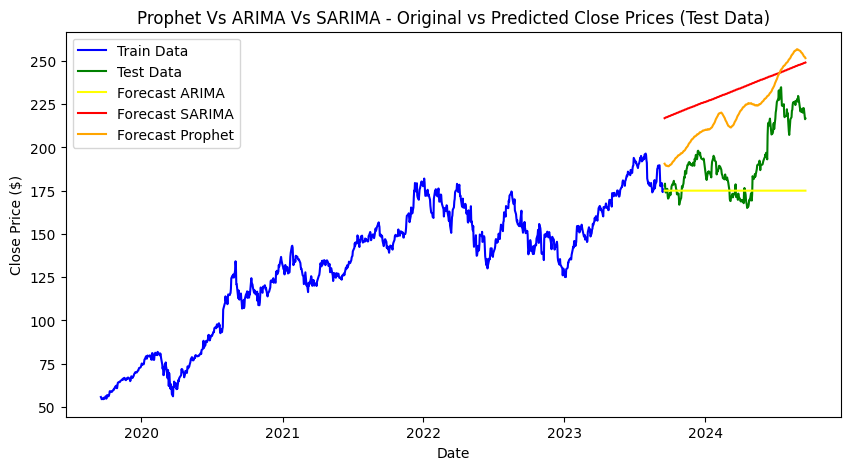

In [27]:
df_fct['fct_prophet'] = None # Initialize the column with None values
df_fct.loc[df_test.index, 'fct_prophet'] = fct_prophet['yhat'].values

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(df_train.index, df_train, label='Train Data', color='blue')
plt.plot(df_test.index, df_test, label='Test Data', color='green')
plt.plot(df_fct.index, df_fct['fct_arima'], label='Forecast ARIMA', color='yellow')
plt.plot(df_fct.index, df_fct['fct_sarima'], label='Forecast SARIMA', color='red')
plt.plot(df_fct.index, df_fct['fct_prophet'], label='Forecast Prophet', color='orange')

plt.title('Prophet Vs ARIMA Vs SARIMA - Original vs Predicted Close Prices (Test Data)')
plt.xlabel('Date')
plt.ylabel('Close Price ($)')
plt.legend()
plt.show()

#### Evaluate the prophet model (cross validation)

In [28]:
df_prophet = df.reset_index().rename(columns={'Date': 'ds', 'Close': 'y'})
df_prophet.head()

,ds,Open,High,Low,y,Adj Close,Volume
0,2019-09-18,55.264999,55.712502,54.860001,55.692501,53.890518,101360000
1,2019-09-19,55.502499,55.939999,55.092499,55.240002,53.452652,88242400
2,2019-09-20,55.345001,55.639999,54.367500,54.432499,52.671284,221652400
3,2019-09-23,54.737499,54.959999,54.412498,54.680000,52.910774,76662000
4,2019-09-24,55.257500,55.622501,54.297501,54.419998,52.659187,124763200


In [29]:
m = Prophet().fit(df_prophet)
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon='365 days')
df_cv.head()

14:23:50 - cmdstanpy - INFO - Chain [1] start processing
14:23:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

14:23:51 - cmdstanpy - INFO - Chain [1] start processing
14:23:51 - cmdstanpy - INFO - Chain [1] done processing
14:23:51 - cmdstanpy - INFO - Chain [1] start processing
14:23:51 - cmdstanpy - INFO - Chain [1] done processing
14:23:52 - cmdstanpy - INFO - Chain [1] start processing
14:23:52 - cmdstanpy - INFO - Chain [1] done processing
14:23:53 - cmdstanpy - INFO - Chain [1] start processing
14:23:53 - cmdstanpy - INFO - Chain [1] done processing
14:23:53 - cmdstanpy - INFO - Chain [1] start processing
14:23:53 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2021-09-29,142.532057,138.414447,146.779868,142.830002,2021-09-28
1,2021-09-30,142.581522,138.427648,146.642629,141.500000,2021-09-28
2,2021-10-01,142.644266,138.366126,146.749841,142.649994,2021-09-28
3,2021-10-04,143.492947,139.456914,147.348482,139.139999,2021-09-28
4,2021-10-05,143.812445,139.671059,148.077798,141.110001,2021-09-28


## Comparison of metrics - SARIMA vs Prophet models

In [30]:
mae_prophet = mean_absolute_error(y_true=df_cv['y'],
                   y_pred=df_cv['yhat'])
mape_prophet = mean_absolute_percentage_error(y_true=df_cv['y'],
                   y_pred=df_cv['yhat'])*100
rmse_prophet = np.sqrt(mean_squared_error(y_true=df_cv['y'],
                   y_pred=df_cv['yhat']))

performance = pd.DataFrame({
    'Metrics': ['MAE', 'MAPE', 'RMSE'],
    'SARIMA': [avg_mae_sarima, f'{avg_mape_sarima:.2f}%', avg_rmse_sarima],
    'Prophet': [mae_prophet, f'{mape_prophet:.2f}%', rmse_prophet],
})

print(performance.set_index('Metrics'))

            SARIMA    Prophet
Metrics                      
MAE      71.522961     36.974
MAPE        49.53%     22.17%
RMSE     72.933469  43.549275


#### ✨ The more effective model is the one with the lower MAPE : PROPHET ✨

## 2-Year forecast using the best model

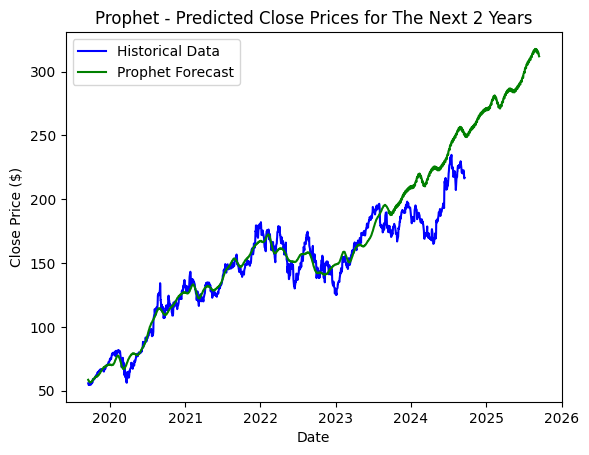

In [31]:
year = 2
steps = year * 365   # Number of steps to forecast (daily data)
df = df.reset_index() # Reset index

# Create future dataframe and predict
future_prophet = m_prophet.make_future_dataframe(periods=steps, freq='D')
prophet_forecast = m_prophet.predict(future_prophet)

# Plot
plt.plot(df2.index, df2['Close'], label='Historical Data', color='blue')
plt.plot(prophet_forecast['ds'], prophet_forecast['yhat'], label='Prophet Forecast', color='green')

plt.title(f"Prophet - Predicted Close Prices for The Next {year} Years")
plt.ylabel('Close Price ($)')
plt.xlabel('Date')
plt.legend()
plt.show()